<h1>Markov Chain Simulation by Method of Perturbation</h1>

The purpose of this notebook is to demonstrate perturbation of the transition probabilty matrix based on historical data. In a multi-touch attribution settings, if customer journeys are modeld via a Markov chain, the transition probability matrix (TPM) will describe the probability of transitioning from one channel to another. **Assuming** that an increase in spend of one `channel` is going to show its greatest effect on the transition from the start of customer journey to that `channel`, the transition probability matrix is perturbed to digest the effect of that increase. Perturbation refers to manually changing one transition probability in the TPM and simulate its effect on other transition probabilities since it is safe to assume that transition probabilities in each row and column are correlated.

## 1. Simulation model <a name="se:sim-model"></a>

In this section, the simulation model for perturbing the transition probability matrix is described in a series of steps for each row of the transition probability matrix. ***NOTE*** that this method does not take spend data into account and only assumes that with increased spend on a specific `<channel>`, the transition probabilities from and to that channel will change. It is assumed that the most onbvious effect/change may reveal itself in the transition probability of `Start -> <channel>`. All other transition probabilities are evaluated based on the change in this probability with respect to historical data. However, any uderlying model fitted to the data should be able to produce predictions that sum to `one` in any row of the transition probability matrix.

Therefore, the simulation starts by assuming a certain amount of increase in transition probability of `Start -> <channel>`. Simulating over different increments for different `<channel>` and comparing the conversion results can indicate, potentially, a channel that is most suitable for an increase in spend.

**First step:** <a name="model-1"></a>

Assuming a change in the transition probability of `start -> ch1`, other probabilities in the same row should <img align="right" src="sim_model_1.png" width="400"> change since the probabilities in any row of the transition probability matrix should sum to `one`. There are a couple of approaches to keeping the sum equal to one. The easiest, would be to pick a `sink` channel and decrease its probability such that the sum remains one. Multiple `sink` channels can also be picked for *cannibalization* where their probabilities  are decreased by equal amounts or in a linearly affine fashion. However, a more comprehensive approach may be to consider that some channel's probabilities may also increase at the same time. To capture these effects and also keep the predictions sum constant, a ***compositional regression*** analysis is adapted where data is transformed according to ***additive log-ratio*** transformation. In this specific case, the compositional regression is also equivalent to a ***multinomial logistic regression***. For each transition probability in the first row, i.e., $P_{\text{start}\rightarrow\text{ch}_j}$, a regression of the following form is fitted:

$$ \log(\frac{P_{\text{start}\rightarrow\text{ch}_j}}{P_{\text{start}\rightarrow\text{ch*}}}) = \beta_0^j + \beta_1^j P_{\text{start}\rightarrow\text{ch}_1}$$

where $P_{\text{start}\rightarrow\text{ch*}}$ can be any channel with non-zero probability of transition. The above regression should be fitted for all channels in the first row except for `ch1` and `ch*`. The predictions from these linear regressions will form a system of linear equations which if solved result in transition probabilities that keep the sum of `Start` row equal to one.

$$
\begin{bmatrix} 
    1 & 1 & 1 & \ldots & 0 & 1\\
    1 & 0 & 0 & \ldots & 0 & -\hat{y}_2\\
    0 & 1 & 0 & \ldots & 0 & -\hat{y}_3\\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
    0 & 0 & 0 & \ldots & 1 & -\hat{y}_n
\end{bmatrix}
\begin{bmatrix}
    P_{\text{start}\rightarrow\text{ch}_2} \\
    P_{\text{start}\rightarrow\text{ch}_3} \\
    \vdots\\
    \vdots\\
    P_{\text{start}\rightarrow\text{ch}*}\\
\end{bmatrix}
=
\begin{bmatrix}
    1 - P_{\text{start}\rightarrow\text{ch}_1} \\
    0\\
    0\\
    \vdots\\
    0
\end{bmatrix}$$

where $\hat{y}_j = \exp(\beta_0^j + \beta_1^j \hat{P}_{\text{start}\rightarrow\text{ch}_1})$. The result of this process will produce transition probabilities of the new `Start` row.

**Second step:** <a name="model-2"></a>

In the section, it is assumed that an increase in probability of `Start -> ch1` will primarily affect the following <img align="right" src="sim_model_2.png" width="400"> transition probabilities: `ch1 -> CONVERSION` and `ch1 -> ch1`. Based on some experiments and informed by business insights, `ch1 -> CONVERSION` transition probabilities are modeled via a linear relationship on logarithmic scale to capture the effects of diminishing returns. `ch1 -> ch1` transition probability is assumed to be linear for all channels. Therefore, the following regressions are fitted in this step to evaluate $P_{\text{ch1}\rightarrow\text{conversion}}$ and $P_{\text{ch1}\rightarrow\text{ch1}}$.

$$
\begin{equation}
P_{\text{ch1}\rightarrow\text{conversion}} = \beta_0^c + \beta_1^c \log(P_{\text{start}\rightarrow\text{ch1}})
\end{equation}
$$

$$
\begin{equation}
P_{\text{ch1}\rightarrow\text{ch1}} = \beta_0^1 + \beta_1^1 P_{\text{start}\rightarrow\text{ch1}}
\end{equation}
$$

However, in implementing the first relationship, all potential transformations of the following forms are considered: $ y\sim x, \log(y)\sim x, \log(y)\sim \log(x), y\sim\log(x),$ and $y\sim\sqrt x$. To evaluate the best fit, the Pearson correlation coefficient is used to identify the relationship that shows the most correlation. The regression is then fitted with the best transformation. It may be the case that none of these transformations turn out be capable of describing a significant relationship. In that case, a linear relationship on logarithmic scale is fitted by default.

**Third step:** <a name="model-3"></a>

 <img align="right" src="sim_model_3.png" width="400"> After predicting new values for $P_{\text{ch1}\rightarrow\text{conversion}}$ and $P_{\text{ch1}\rightarrow\text{ch1}}$, the rest of transition probabilities in row of `ch1` should change in such a way that the sum of transition probabilites in row `ch1` remains 1. To that end, a similar approach to the [first step](#model-1) with small modifications is considered here as well.

$$
\log(\frac{P_{\text{ch}_1\rightarrow\text{ch}_j}}{P_{\text{ch}_1\rightarrow\text{ch*}}}) = \beta_0^j + \beta_1^j P_{\text{ch}_1\rightarrow\text{conversion}} + \beta_2^j P_{\text{ch}_1\rightarrow\text{ch}_1}
$$

The system of linear equation here is also setup similar to that of the [first step](#model-1). However, in this step, $\hat{y}_j$ are evaluated differently and according to the modified regression

$$
\hat{y}_j = \exp(\beta_0^j + \beta_1^j P_{\text{ch}_1\rightarrow\text{conversion}} + \beta_2^j P_{\text{ch}_1\rightarrow\text{ch}_1})
$$

Furthermore, the first value of the right hand side matrix in the linear system $[A][x] = [b]$ will change to 
$
1 - P_{\text{ch}_1\rightarrow\text{conversion}} - P_{\text{ch}_1\rightarrow\text{ch}_1}
$.

**Fourth step:** <a name="model-4"></a>

<img align="right" src="sim_model_4.png" width="400"> In this step, it is assumed that an increase in the transition probability of `Start -> ch1` will also have an affect of transition probabilies of all other channels to `ch1`, e.g., `ch2 -> ch1`. After some experiments, these types of relationships can be explaind in a linear fashion reasonably well. Therefore, all transition probabilities of the form $P_{\text{ch}_j\rightarrow\text{ch}_1}$ can be linearly regressed on $P_{\text{start}\rightarrow\text{ch}_1}$. However, note that in implementation, only significant relationship are considered and transition probabilies whose `r-squared` metric is below a threshold, are assumed to remain constant and do not change. This process is repeated for every row of in `ch1` column.

**Fifth step:** <a name="model-5"></a>

<img align="right" src="sim_model_5.png" width="400"> Having predicted a new value for a transition from any other channel to `ch1`, e.g., `ch2 -> ch1`, the transition probabilities in row of `ch2` should change to keep the sum of all probabilies in the row equal to 1. This is done in a similar fashion to [first step](#model-1). ***NOTE*** that the [forth](#model-4) and [fifth](#model-5) steps are repeated for every row in the column of `ch1`.

## 2. Read-in sample data base <a name="se:data"></a>

The sample data base read here is constructed by stacking `9` different transition probabilities for different time periods. The data goes through several steps of preprocessing for ease of later use in the simulation. First, row and columns are ordered. **NOTE** that in this case, rows refer to the origin of transition (i.e., `from_channel`), and columns refer to the destination of transition (i.e., `to_channel`). Then, time period which is of type string is converted to a date type object. Finally, the stacked transition probabilities are melted into a long format for easier use later in the simulation. **NOTE** that, at this stage, the latest transition probability (`latest_transition_mat`) is also extracted for later comparisons.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
transition_df = pd.read_csv(os.path.join(parent_dir, 
                                         '../Data Transformations/raw data/transition_matrices_sample_data.csv'), 
                            index_col = 0,
                            sep = ',',
                            header = 0)

In [2]:
## row and column order definitions
ordered_col = [state for state in sorted(transition_df.columns) 
                         if state not in ['CONVERSION', 'Null', 'Start', 'Time_Period']]
ordered_col = ordered_col + ['Null', 'CONVERSION', 'Time_Period']
ordered_row = [state for state in sorted(transition_df.index.unique()) 
                         if state not in ['CONVERSION', 'Null', 'Start', 'Time_Period']]
ordered_row = ['Start'] + ordered_row
transition_df = transition_df.loc[transition_df.index.isin(ordered_row), ordered_col]

In [3]:
import datetime as dt
## date cleanup
transition_df['Time_Period'] = transition_df['Time_Period'].str.replace(' ', '')
transition_df['Time_Period'] = transition_df['Time_Period'].apply(lambda str_date: 
                                                                      dt.datetime.strptime(str_date, '%y-%b')\
                                                                                 .strftime('%B %Y'))
transition_df['Time_Period'] = pd.to_datetime(transition_df.Time_Period)

In [4]:
## filter the latest transition matrix for comparison
latest_transition_mat = transition_df[transition_df.Time_Period == transition_df.Time_Period.max()]
latest_transition_mat = latest_transition_mat.reindex(index = ordered_row)
latest_transition_mat.head()

,AFFILIATE|DESKTOP,AFFILIATE|MOBILE,B2B|DESKTOP,B2B|MOBILE,DIRECT|DESKTOP,DIRECT|MOBILE,DISPLAY|DESKTOP,DISPLAY|MOBILE,ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP,ECONFO AND PRE-ARRIVAL EMAIL|MOBILE,...,RESLINK|MOBILE,SOCIAL MEDIA|DESKTOP,SOCIAL MEDIA|MOBILE,TEST|DESKTOP,TEST|MOBILE,UNPAID REFERRER|DESKTOP,UNPAID REFERRER|MOBILE,Null,CONVERSION,Time_Period
Start,0.011280,0.001963,0.000003,4.520000e-07,0.199898,0.354996,0.001787,0.000393,0.005080,0.002650,...,0.004881,0.000312,0.000203,0.000005,0.000001,0.018392,0.004869,0.000000,0.000000,2021-09-01
AFFILIATE|DESKTOP,0.248384,0.000870,0.000000,0.000000e+00,0.114571,0.087901,0.001740,0.000105,0.003697,0.000082,...,0.000111,0.000549,0.000023,0.000017,0.000000,0.015032,0.000199,0.124709,0.192643,2021-09-01
AFFILIATE|MOBILE,0.008596,0.194579,0.000000,0.000000e+00,0.018559,0.120879,0.000049,0.001758,0.000195,0.002979,...,0.067204,0.000000,0.000098,0.000000,0.000000,0.001368,0.010110,0.222125,0.189109,2021-09-01
B2B|DESKTOP,0.000000,0.000000,0.260870,0.000000e+00,0.043478,0.217391,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.130435,0.217391,2021-09-01
B2B|MOBILE,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2021-09-01


In [5]:
## melt transition prob matrix to long format
transition_df = pd.melt(transition_df.reset_index(),
                        id_vars = ['index', 'Time_Period'],
                        value_vars = transition_df.columns[transition_df.columns != 'Time_Period'],
                        var_name = 'to_state',
                        value_name = 'trans_prob')
## change col names and types
transition_df.rename(columns = {'index': 'from_state',
                                'Time_Period': 'period'},
                     inplace = True)
transition_df = transition_df.reindex(columns = ['from_state', 'to_state', 'trans_prob', 'period'])
transition_df['from_state'] = pd.Categorical(transition_df['from_state'], ordered_row)
transition_df['to_state'] = pd.Categorical(transition_df['to_state'], ordered_col)
transition_df = transition_df.sort_values(['period', 'from_state', 'to_state'])
transition_df.head()

,from_state,to_state,trans_prob,period
24,Start,AFFILIATE|DESKTOP,0.010866,2021-01-01
285,Start,AFFILIATE|MOBILE,0.002591,2021-01-01
546,Start,B2B|DESKTOP,0.000006,2021-01-01
807,Start,B2B|MOBILE,0.000000,2021-01-01
1068,Start,DIRECT|DESKTOP,0.194357,2021-01-01


## 3. Scenario planning <a name="se:scenario"></a>

Only a limited number of channels are selected to be simulated. For example, in this case, only the channels in the `sim_channels` will be used to perturb the transition probability matrix. **NOTE** that the amount by which the `Start -> channel` transition probability will increase in the simulation is denoted in `increment_lst`.

In [6]:
## channels to simulate for trans prob increase
sim_channels = ['AFFILIATE|DESKTOP', 'AFFILIATE|MOBILE', 'DISPLAY|DESKTOP', 'DISPLAY|MOBILE', 'EMAIL|DESKTOP',
                'EMAIL|MOBILE', 'PAID SEARCH|DESKTOP', 'PAID SEARCH|MOBILE', 'REFERRAL ENGINE|DESKTOP',
                'REFERRAL ENGINE|MOBILE', 'SOCIAL MEDIA|DESKTOP', 'SOCIAL MEDIA|MOBILE']

In [7]:
## initial transition increments
increment_lst = [0.01, 0.02, 0.05, 0.1] #percentages

## 4. Implementation <a name="se:implement"></a>

In this implementation, the simulation model described in [Section 1](#se:sim-model) is implemented via three main functions that given a channel and a increase in percentage in the transition probability of `Start -> <channel>`, 
1. simulate the first row of the transition probability matrix, i.e., the row for which `from_state` is `Start`, 
2. simulate the `<channel>` row of the transition probability matrix,
3. and simulate other rows of the transition probability matrix.

This is done because the simulation procedure for each row may be different.

### 4.1. Helper functions <a name ="sse:implement-helper"></a>

Here, we first describe helper functions that allow for different regression and prediction operations.

#### 4.1.1. Sink channels <a name ="ssse:helper-sink"></a>
The `find_sink_channels_func` is defined to identify potential sink channels in each row of the transition probability matrix for cannibalization. Increasing a transition probability in a row would force one or potentially more than one other transition probabilities to decrease such that the total sum of probabilities adds up to 1. Therefore, given a channel's row with a column where probability is going to increase, all other columns with transition probabilities greater than `0` are candidates for cannibalization. The exception is for cases when `CONVERSION` is also marked for probability increase.

In [8]:
def find_sink_channels_func(row, col, transition_df, include_conv = False):
    '''
        determines potential sink channels for cannibalization
        for each row, all columns except 'Start', 
                                         the column considered for transition prob increase,
                                         and the column = row
                                         and depending on the simulation mode, 'CONVERSION'
        are potential sink channels if their transition prob > 0
    '''
    import pandas as pd
    candidate_sinks = transition_df.to_state.unique()
    if include_conv:
        candidate_sinks = candidate_sinks[~candidate_sinks.isin([row, col, 'CONVERSION'])]
    else:
        candidate_sinks = candidate_sinks[~candidate_sinks.isin([row, col])]
    candidate_sinks = [candidate for candidate in candidate_sinks
                       if all(transition_df.loc[(transition_df.from_state == row) & 
                                            (transition_df.to_state == candidate), 'trans_prob'].values > 0)]
    return candidate_sinks

#### 4.1.2. Compositional regression <a name ="ssse:help-comp-reg"></a>

To keep the sum of probabilities in each row constant and equal to `1`, the simplest form of compositional regressions is used in the funtion `compositional_regression_func` below. This function implements the regression operations described in the [first step](#model-1) of the simulation model in [Section 2](#se:sim-model). After potential sink channels have been determined, their transition probabilities construct a response vector having gone through an additive log-ratio transformation according 

$$(P_{i, 1}, P_{i, 2}, \ldots, P_{i, n}) \rightarrow (\log\frac{P_{i, 1}}{P_{i, n}}, \log\frac{P_{i, 2}}{P_{i, n}}, \ldots, \log\frac{P_{i, n-1}}{P_{i, n}}).$$

After transformation, transition probabilties of potential sink channels are linearly regressed on transition probabilities that are increased manually according to scenario planning or have changes as the result of previous simulation of rows.

$$ \log(\frac{P_{i, j}}{P_{i, n}}) = \beta_0^j + \beta_1^j P_{i, \text{ch*}} + \beta_2^j P_{i, c} \mathbb{1}_{\{\text{conversion is not a sink}\}}$$

where $P_{i, j}$ is the transition probability of interest for prediction. $P_{i, n}$ is the last transition probability of potential sink channels used for additive log-ratio transformation. $P_{i, \text{ch*}}$ is the transition probability of the channel that has been manually increased or has been changed as the result of previous simulation steps. If `CONVERSION` is not one of the potential sink channels, hence $\mathbb{1}_{\{\text{conversion is not a sink}\}} = 1$. Then, $P_{i, c}$ denotes the transition probability to conversion and is added as an independent feature of the regression.

In [9]:
def compositional_regression_func(row, col, candidate_sinks, last_item, transition_df, include_conv = False):
    '''
    compositional linear regression: sum of response variables is constrained 
        -data are transformed according to additive log-ratio compositional regression
        -(x1, x2, x3) --> (log(x1/x3), log(x2/x3))
        -linear regression over transformed data
    '''
    import pandas as pd
    import numpy as np
    def regression_func(x, y):
        '''
        returns intercept, coefficient, and r^2 score of y ~ b0 + bx
        '''
        from sklearn import linear_model
        reg = linear_model.LinearRegression()
        reg.fit(x, y)
        return reg.intercept_[0], reg.coef_[0], reg.score(x, y)
    
    def log_ratio_func(trans_prob, period, last_item, transition_df):
        import numpy as np
        return np.log(trans_prob / transition_df.loc[(transition_df.period == period) & 
                                                     (transition_df.to_state == last_item), 'trans_prob'].values[0])
    
    ## filter transition prob for row and candidate sinks + col
    if include_conv:
        transition_df = transition_df.loc[(transition_df.from_state == row) & 
                                          (transition_df.to_state.isin(candidate_sinks + [col, 'CONVERSION'])),]
    else:
        transition_df = transition_df.loc[(transition_df.from_state == row) & 
                                          (transition_df.to_state.isin(candidate_sinks + [col])),]
    
    ## log-ratio transformation 
    transition_df['log_ratio'] = transition_df.apply(lambda x: log_ratio_func(x['trans_prob'],
                                                                              x['period'],
                                                                              last_item,
                                                                              transition_df), 
                                                     axis = 1)
    regression_res = pd.DataFrame(columns = ['channel', 'intercept', 'coef', 'r2'])
    for channel in candidate_sinks[:-1]:
        y = np.array(transition_df.loc[transition_df.to_state == channel, 'log_ratio']).reshape(-1, 1)
        if include_conv:
            x = np.array(transition_df.loc[transition_df.to_state.isin([col, 'CONVERSION']), 'trans_prob']).reshape(-1, 2)
        else:
            x = np.array(transition_df.loc[transition_df.to_state == col, 'trans_prob']).reshape(-1, 1)
        intercept, coef, r2 = regression_func(x, y)
        regression_res = regression_res.append(
            pd.DataFrame([[channel, intercept, coef, r2]],
                         columns = ['channel', 'intercept', 'coef', 'r2'])
        )
    return regression_res

#### 4.1.3. Compositional predictions <a name ="ssse:help-comp-pred"></a>

The predictions from compositional regression for a row of the transition probability matrix should add up to `1`. The function `predict_compostional_response_func` implements the process described in [first step](#se:model-1) of [Section 1](#se:sim-model). Having identified potential sink channels, transition probabilities of the remaining channels in a row are subtracted from `1`. Then, a system of linear equations similar to the [first step](#se:model-1) are constructed and are solved to evaluate new transition probabilities for all channels in a row of transition probability matrix.

As a result of compositional regression, new predictions for $\log\frac{P_{i, j}}{P_{i, n}}$ will become available. To transfrom bakc these predictions to a series of $(P_{i, 1}, P_{i, 2}, \ldots, P_{i, n})$ that sum to `1`, $n + 1$ linear equations of the following need to be solved

$$
\begin{bmatrix} 
    1 & 1 & 1 & \ldots & 0 & 1\\
    1 & 0 & 0 & \ldots & 0 & -\hat{y}_1\\
    0 & 1 & 0 & \ldots & 0 & -\hat{y}_2\\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
    0 & 0 & 0 & \ldots & 1 & -\hat{y}_{n-1}
\end{bmatrix}
\begin{bmatrix}
    P_{i, 1} \\
    \vdots\\
    P_{i, j}\\
    \vdots\\
    P_{i, n}\\
\end{bmatrix}
=
\begin{bmatrix}
    1 - P_{i, \text{ch*}} -  P_{i, c} \mathbb{1}_{\{\text{conversion is not a sink}\}}\\
    0\\
    0\\
    \vdots\\
    0
\end{bmatrix}$$

where $\hat{y}_j = \exp(\beta_0^j + \beta_1^j \hat{P}_{i, j})$.

In [10]:
def predict_compostional_response_func(row, col, sinks_df, last_item, transition_df, change_pct, include_conv = False):
    '''
    predict new row based on regression analysis
        -filter out constant channels
        -calculate the remaining constant from 1
        -evaluate new_y w.r.t. simulation percentage change
        -predict log-ratio of sink channels
        
    '''
    import pandas as pd
    import numpy as np
    ## calculate trans prob of unchanged channels
    if include_conv:
        const_channels = set(transition_df.to_state) - set(list(sinks_df.channel) + [last_item, col, 'CONVERSION'])
    else:
        const_channels = set(transition_df.to_state) - set(list(sinks_df.channel) + [last_item, col])
    latest_period = transition_df.period.max()
    const_remain = 1 - transition_df.loc[(transition_df.from_state == row) & 
                                         (transition_df.to_state.isin(const_channels)) & 
                                         (transition_df.period == latest_period),]['trans_prob'].sum()
    
    ## evaluate new trans prob for simulated channel
    if include_conv:
        new_y = transition_df.loc[(transition_df.from_state == row) &
                                  (transition_df.to_state == col) &
                                  (transition_df.period == latest_period), 'trans_prob'].values[0]
        new_y += new_y * change_pct[1]
        new_conv = transition_df.loc[(transition_df.from_state == row) &
                                     (transition_df.to_state == 'CONVERSION') &
                                     (transition_df.period == latest_period), 'trans_prob'].values[0]
        new_conv += new_conv * change_pct[0]
        ## predict new ratios for sink channels
        sinks_df[['coef_0', 'coef_1']] = pd.DataFrame(sinks_df.coef.tolist(), index = sinks_df.index)
        sinks_df['new_ratio'] = np.exp(sinks_df['intercept'] + sinks_df['coef_0'] * new_y + sinks_df['coef_1'] * new_conv)
    else:
        new_y = transition_df.loc[(transition_df.from_state == row) &
                                  (transition_df.to_state == col) &
                                  (transition_df.period == latest_period), 'trans_prob'].values[0]
        new_y += new_y * change_pct[0]
    
        ## predict new ratios for sink channels
        sinks_df['coef'] = pd.DataFrame(sinks_df.coef.tolist(), index = sinks_df.index)
        sinks_df['new_ratio'] = np.exp(sinks_df['intercept'] + sinks_df['coef'] * new_y)
    
    ## construct a linear system for solution
    A = np.array([[1 for i in range(len(sinks_df) + 1)]])
    for i, channel in enumerate(sinks_df.channel):
        eq = [0 for i in range(len(sinks_df) + 1)]
        eq[i] = 1
        eq[-1:] = [-sinks_df.new_ratio[i]]
        A = np.append(A, [eq], axis = 0)
    if include_conv:
        b = np.array([const_remain - new_y - new_conv] + [0 for i in range(len(sinks_df))])
    else:
        b = np.array([const_remain - new_y] + [0 for i in range(len(sinks_df))])

    def solve_linear_system(A, b):
        '''
        return the solution to system Ax = b
        '''
        import numpy as np
        from scipy import linalg
        return np.linalg.solve(A, b)
    
    sink_trans_prob = solve_linear_system(A, b)
    return zip(list(sinks_df.channel) + [last_item], sink_trans_prob)

#### 4.1.4. Best transformation for linear relationship <a name ="ssse:help-trans"></a>

To capture the effect of diminishing effect in the relationship between $P_{\text{Start}, \text{ch}}$ and $P_{\text{ch}, \text{CONVERSION}}$, different transformers are tested and the best one is picked according to its Pearson coefficient of correlation where larger values indicate better relationships. These transformations are of the following forms:

$$ y\sim x, \log(y)\sim x, \log(y)\sim \log(x), y\sim\log(x), \text{ and } y\sim\sqrt x$$

The function `descriptor_pick_func` iterates through the above transformations and identifies the best one.

In [11]:
def descriptor_pick_func(row, col, transition_df):
    '''
    choose how to explain the relationship between Start -> channel and channel -> CONVERSION trans prob
    '''
    import pandas as pd
    channel = transition_df.loc[(transition_df.from_state == row) & 
                                (transition_df.to_state == col), 'trans_prob']
    convert = transition_df.loc[(transition_df.from_state == col) & 
                                (transition_df.to_state == 'CONVERSION'), 'trans_prob']
    
    def cor_table(channel, convert):
        '''
        return Pearson's correlation between different func(x)~func(y)
        '''
        import pandas as pd
        import numpy as np
        from scipy.stats.stats import pearsonr
        cor_table = np.abs(pd.Series(data = [pearsonr(channel, convert)[0], #x~y
                                             pearsonr(np.log(channel), np.log(convert))[0], #log(x)~log(y)
                                             pearsonr(np.log(channel), convert)[0], #log(x)~y
                                             pearsonr(channel, np.log(convert))[0], #x~log(y)
                                             pearsonr(channel, np.sqrt(convert))[0]], #x~sqrt(y)
                                     index = ['x-y', 'logx-ylog', 'xlog-y', 'x-ylog', 'x-ysqrt']))
        return cor_table.max(), cor_table.idxmax()
    return cor_table(channel, convert)

#### 4.1.5. Linear regression and prediction <a name="ssse:help-lin-reg"></a>

Depending on the best transformation that explains the highest variation, the function `linear_regression_func` below, regresses a transition probability on another. These linear regressions apply to 

$$
\begin{equation}
P_{\text{ch}\rightarrow\text{conversion}} = \beta_0^c + \beta_1^c f(P_{\text{Start}\rightarrow\text{ch}})
\end{equation}
$$

or

$$
\begin{equation}
P_{\text{ch}\rightarrow\text{ch}} = \beta_0^1 + \beta_1^1 f(P_{\text{Start}\rightarrow\text{ch}})
\end{equation}
$$

cases where $f(\cdots)$ denotes a tranformation on either or both independent and response variables. The function `new_trans_prob_func` below will predict new transition probabilities given regression coefficients and the transformation function.

In [12]:
def linear_regression_func(row, col, transition_df, method, include_conv = True):
    '''
    given transformation method, fits a linear regression
    '''
    import pandas as pd
    import numpy as np
    channel = transition_df.loc[(transition_df.from_state == 'Start') & 
                                (transition_df.to_state == col), 'trans_prob']
    if include_conv:
        convert = transition_df.loc[(transition_df.from_state == col) & 
                                    (transition_df.to_state == 'CONVERSION'), 'trans_prob']
    else:
        convert = transition_df.loc[(transition_df.from_state == row) & 
                                    (transition_df.to_state == col), 'trans_prob']
    x = np.array(channel).reshape(-1, 1)
    y = np.array(convert).reshape(-1, 1)
    
    if method == 'logx-ylog':
        x = np.log(x)
        y = np.log(y)
    elif method == 'xlog-y':
        x = np.log(x)
    elif method == 'x-ylog':
        y = np.log(y)
    elif method == 'x-ysqrt':
        y = np.sqrt(y)
    
    def regression_func(x, y):
        '''
        returns intercept, coefficient, and r^2 score of y ~ b0 + bx
        '''
        from sklearn import linear_model
        reg = linear_model.LinearRegression()
        reg.fit(x, y)
        return reg.intercept_[0], reg.coef_[0][0], reg.score(x, y)
    
    return regression_func(x, y)

In [13]:
def new_trans_prob_func(intercept, coef, trans_prob, method):
    '''
    given transformation method, determines new conversion rate
    '''
    import numpy as np
    if method == 'logx-ylog':
        new_conv = np.exp(intercept + coef * np.log(trans_prob))
    elif method == 'xlog-y':
        new_conv = intercept + coef * np.log(trans_prob)
    elif method == 'x-ylog':
        new_conv = np.exp(intercept + coef * trans_prob)
    elif method == 'x-ysqrt':
        new_conv = (intercept + coef * trans_prob)**2
    else:
        new_conv = intercept + coef * trans_prob
        
    return new_conv

#### 4.1.6. New row construction <a name="ssse:help-row"></a>

After new transition probabilities are evaluated based on linear or compositional regressions, a new row of the transition probability matrix is put together. This row is constructed by appending new transition probabilities and those that remained constant during a specific perturbation scenario.

In [14]:
def construct_transition_rows_func(row, new_trans_df, old_trans_df):
    '''
        construct a new transition matrix row given new and old transition probabilites
    '''
    import pandas as pd
    new_row = pd.DataFrame(columns = old_trans_df.to_state, index = [row])
    new_row[list(new_trans_df.to_state)] = new_trans_df.trans_prob.values
    new_row[list(old_trans_df.to_state)] = old_trans_df.trans_prob.values
    return new_row

### 4.2. Main functions <a name="sse:implement-main"></a>

Here, the main simulation functions that simulate each row of the transition probability matrix are described. Hereafter, the transition probability matrix is referred to as **TPM** in the titles.

#### 4.2.1. Simulation of the `Start` row of TPM <a name="ssse:main-first"></a>

The key assumption in this simulation model is that increasing spend on one channel will realize its most effect in the transition probability of `Start -> that channel`. Therefore, the only perturbed transition probability that is increased manually (i.e., according to the scenario planner) is the transition probability of $P_{\text{Start}, \text{ch}}$. In the `Start` row of the transition probability matrix, transitions to `LOSS` or `CONVERSION` is set to zero since no customer journeys directly end up in one of the two absorbing states. Therefore, the remaining non-zero transition probability functions should be determined according to a compositional regression.

The function `simulate_first_row_func` implements the simulation process described in the [first step](#se:model-1) of the simulation model in [Section 1](#se:sim-model). Potential sink candidates are first determined by calling the `find_sink_channels_func` helper function. Then, last potential sink candidates is identified for the additive log-ration transformation of the compositional regression. `compositional_regression_func` function is called to carry the compositional regression where the transition probability of each potential sink channel is regressed on the transition probability from `Start -> channel`. Having the regression models, the new transition probabilities for sink channels are evaluated by the `predict_compostional_response_func` function such that the entire row's sum remains `1`. With these results, a new first row is constructed for the transition probability matrix by the `construct_transition_rows_func` function.

The internal process of helper functions, `find_sink_channels_func`, `compositional_regression_func`, `predict_compostional_response_func` and `construct_transition_rows_func` is described in the previous subsection [Helper functions](#sse:implement-helper).

In [15]:
def simulate_first_row_func(channel, inc, transition_df):
    '''
        simulate start row: increase <channel> trans prob and cannibalize others accordingly
            -for each channel, a list of <candidate_sinks> are generated for cannibalization
            -the amount of cannibalization is determined by a compositional regression analysis
            -sink channels are selected based on the result of regression, r^2 >= 0.75
            -new row is predicted based on regression
    '''
    import pandas as pd
    ## first step in the simulation model
    candidate_sinks = find_sink_channels_func('Start', 
                                              channel, 
                                              transition_df)
    last_item = candidate_sinks[-1:][0]
    regression_res_df = compositional_regression_func('Start', 
                                                      channel, 
                                                      candidate_sinks, 
                                                      last_item, 
                                                      transition_df)
    ## NOTE: temporary solution; should update
    #inks_df = regression_res_df[regression_res_df.r2 > 0.75].reset_index(drop = True)
    sinks_df = regression_res_df.sort_values(by = 'r2', ascending = False).head(5).reset_index(drop = True)
    trans_prob = predict_compostional_response_func('Start', 
                                                    channel, 
                                                    sinks_df, 
                                                    last_item, 
                                                    transition_df, 
                                                    [inc])
    new_trans_df = pd.DataFrame(list(trans_prob), columns = ['to_state', 'trans_prob'])
    new_st_chnnl_prob = transition_df.loc[(transition_df.from_state == 'Start') & 
                                          (transition_df.to_state == channel) & 
                                          (transition_df.period == transition_df.period.max()), 'trans_prob'] + \
                            transition_df.loc[(transition_df.from_state == 'Start') & 
                                              (transition_df.to_state == channel) & 
                                              (transition_df.period == transition_df.period.max()), 'trans_prob'] * inc
    new_trans_df = new_trans_df.append(pd.DataFrame([[channel, new_st_chnnl_prob]], 
                                                    columns = ['to_state', 'trans_prob']))
    old_trans_df = transition_df.loc[(transition_df.from_state == 'Start') & 
                                     (~transition_df.to_state.isin(new_trans_df.to_state)) & 
                                     (transition_df.period == transition_df.period.max()), ['to_state', 'trans_prob']]
    new_row = construct_transition_rows_func('Start',
                                             new_trans_df,
                                             old_trans_df)
    return new_row

#### 4.2.2. Simulation of the `channel` row in TPM <a name="ssse:main-channel"></a>

To further simulate the effect of perturbation of the `Start -> channel` transition probability, it is assumed that transition probabilities of `channel -> channel` and `channel -> CONVERSION` would also change in the `channel` row. If both transition probabilities change, then the entire row must be simulated to keep the summation of transition probabilities in the `channel` row equal to `1`. 

The function `simulate_channel_row_func` below implements the simulation process described in [second](#model-2) and [third steps](#model-3) of the simulation model in [Section 1](#se:sim-model). First, transition probabilities of `channel -> channel` and `channel -> CONVERSION` are linearly regressed on the transition probability of `Start -> channel`. This is done by first picking the best transformation that explains the highest variation according to the `descriptor_pick_func` function and then carrying a standard linear regression on the transformed data and response variable with the `linear_regression_func` function. Having determined the change in transition probabilities of `channel -> channel` and `channel -> CONVERSION`, the remaining transition probabilities in the `channel` row must be evaluated according to a compositional regression. Therefore, potential sink candidates are identified, a compositional regression is carried out, new transition probabilities are predicted, and a new `channel` row for the transition probability matrix is constructed.

The internal process of helper functions `descriptor_pick_func` and `linear_regression_func` are described in the previous subsection [Helper functions](#sse:implement-helper).

In [16]:
def simulate_channel_row_func(channel, transition_df):
    '''
        simulate <channel> row: increasing 'Start' -> <channel> will, probably, affect <channel> -> 'CONVERSION'
            -check <channel> -> 'CONVERSION' and 
                   <channel> -> <channel> correlations by measuring correlation of different transformers on data
            -pick the best transformer (if any), regress 'CONVERSION' or <channel> on <channel>
            -repeat the process for the first row:
                -find candidate sink channels
                -determin cannibalization effect
                -construct a new row
    '''
    import pandas as pd
    ## second step in the simulation model
    cor, method = descriptor_pick_func('Start', channel, transition_df)
    if cor < 0.75:
        method = 'xlog-y'
    
    ## calculate st_chnnl ~ chnnl_conversion
    intercept, coef, r2 = linear_regression_func(channel, channel, transition_df, method, include_conv = True)
    old_conv_rate = transition_df.loc[(transition_df.from_state == channel) & 
                                      (transition_df.to_state == 'CONVERSION') & 
                                      (transition_df.period == transition_df.period.max()), 'trans_prob'].values[0]
    st_chnnl_prob = transition_df.loc[(transition_df.from_state == 'Start') & 
                                      (transition_df.to_state == channel) & 
                                      (transition_df.period == transition_df.period.max()), 'trans_prob'].values[0]
    new_conv_rate = new_trans_prob_func(intercept, coef, st_chnnl_prob, method)
    pct_change = [(new_conv_rate - old_conv_rate) / old_conv_rate]
    
    ## calculate st_chnnl ~ chnnl_chnnl
    intercept, coef, r2 = linear_regression_func(channel, channel, transition_df, 'x-y', include_conv = False)
    old_trans_prob = transition_df.loc[(transition_df.from_state == channel) & 
                                       (transition_df.to_state == channel) & 
                                       (transition_df.period == transition_df.period.max()), 'trans_prob'].values[0]
    new_trans_prob = new_trans_prob_func(intercept, coef, st_chnnl_prob, 'x-y')
    pct_change.append((new_trans_prob - old_trans_prob) / old_trans_prob)
    
    ## third step in the simulation
    candidate_sinks = find_sink_channels_func(channel, 
                                              channel, 
                                              transition_df,
                                              include_conv = True)
    last_item = candidate_sinks[-1:][0]
    regression_res_df = compositional_regression_func(channel, 
                                                      channel, 
                                                      candidate_sinks, 
                                                      last_item, 
                                                      transition_df,
                                                      include_conv = True)
    ## NOTE: temporary solution; should update
    #inks_df = regression_res_df[regression_res_df.r2 > 0.75].reset_index(drop = True)
    sinks_df = regression_res_df.sort_values(by = 'r2', ascending = False).head(5).reset_index(drop = True)
    trans_prob = predict_compostional_response_func(channel, 
                                                    channel, 
                                                    sinks_df, 
                                                    last_item, 
                                                    transition_df, 
                                                    pct_change,
                                                    include_conv = True)
    new_trans_df = pd.DataFrame(list(trans_prob), columns = ['to_state', 'trans_prob'])
    new_trans_df = new_trans_df.append(pd.DataFrame([[channel, new_trans_prob],
                                                     ['CONVERSION', new_conv_rate]], 
                                                    columns = ['to_state', 'trans_prob']))
    old_trans_df = transition_df.loc[(transition_df.from_state == channel) & 
                                     (~transition_df.to_state.isin(new_trans_df.to_state)) & 
                                     (transition_df.period == transition_df.period.max()), ['to_state', 'trans_prob']]
    new_row = construct_transition_rows_func(channel, 
                                             new_trans_df, 
                                             old_trans_df)
    return new_row

#### 4.2.3. Simulation of other rows in TPM <a name="ssse:main-other"></a>

Other effects of perturbation of the `Start -> channel` transition probability, is assumed to be captured by the change in transition probability of `other channels -> channel`. Determining this change will also trigger simulation of other rows of the transition probability matrix since sum of every row should remain equal to `1`.

The function `simulate_other_channel_row_func` implements the simulation process described in [fourth](#model-4) and [fifth steps](#model-5) of the simulation model in [Section 2](#se:sim-model). Transition probabilities of `other channel -> channel` in each row of the transition probability matrix can be regressed on `Start -> channel` transition probability to capture the effect of perturbation on other channels. This is done by `linear_regression_func` assuming that no transformation is necessary. This decision, in case of this sample data, is supported by experiments. For other data sets, other forms of relationship can be explored. After determining a new probability for `other channel -> channel` transition, a similar process to previous steps is taken to keep sum of the probabilities in each row equal to `1`. 

In [17]:
def simulate_other_channel_row_func(row, col, transition_df):
    '''
        simulate other channel rows: increasing 'Start' -> <channel> will, probably, affect other channel -> <channel>
            -check <channel> ~ 'CONVERSION' correlation by measuring correlation of different transformers on data
            -pick the best transformer (if any), regress 'CONVERSION' on <channel>
            -repeat the process for the first row:
                -find candidate sink channels
                -determin cannibalization effect
                -construct a new row
    '''
    import pandas as pd
    intercept, coef, r2 = linear_regression_func(row, col, transition_df, 'x-y', include_conv = False)
    st_chnnl_prob = transition_df.loc[(transition_df.from_state == 'Start') & 
                                      (transition_df.to_state == col) & 
                                      (transition_df.period == transition_df.period.max()), 'trans_prob'].values[0]
    old_trans_prob = transition_df.loc[(transition_df.from_state == row) & 
                                       (transition_df.to_state == col) & 
                                       (transition_df.period == transition_df.period.max()), 'trans_prob'].values[0]
    new_trans_prob = new_trans_prob_func(intercept, coef, st_chnnl_prob, 'x-y')
    pct_change = [(new_trans_prob - old_trans_prob) / old_trans_prob]
    
    candidate_sinks = find_sink_channels_func(row, 
                                              col, 
                                              transition_df)
    last_item = candidate_sinks[-1:][0]
    regression_res_df = compositional_regression_func(row, 
                                                      col, 
                                                      candidate_sinks, 
                                                      last_item, 
                                                      transition_df,
                                                      include_conv = False)
    ## NOTE: temporary solution; should update
    #inks_df = regression_res_df[regression_res_df.r2 > 0.75].reset_index(drop = True)
    sinks_df = regression_res_df.sort_values(by = 'r2', ascending = False).head(5).reset_index(drop = True)
    trans_prob = predict_compostional_response_func(row, 
                                                    col, 
                                                    sinks_df, 
                                                    last_item, 
                                                    transition_df, 
                                                    pct_change,
                                                    include_conv = False)
    new_trans_df = pd.DataFrame(list(trans_prob), columns = ['to_state', 'trans_prob'])
    new_trans_df = new_trans_df.append(pd.DataFrame([[col, new_trans_prob]], 
                                                    columns = ['to_state', 'trans_prob']))
    old_trans_df = transition_df.loc[(transition_df.from_state == row) & 
                                     (~transition_df.to_state.isin(new_trans_df.to_state)) & 
                                     (transition_df.period == transition_df.period.max()), ['to_state', 'trans_prob']]
    new_row = construct_transition_rows_func(row, 
                                             new_trans_df, 
                                             old_trans_df)
    return new_row

## 5. Simulation algorithm <a name="se:alg"></a>

The code chunk below implements the overall simulation algorithm described in steps [1](#model-1) through [5](#model-5) of [Section 2](#se:sim-model). Recall from [Section 3](#se:scenario) that each scenario identifies a `channel` for simulation and a percentage for increase in probability of `Start -> channel`. Given that information, the algorithm below first simulates the `Start` row of the transition probability matrix using the `simulate_first_row_func` function described in [Subsection 4.2.1](#ssse:main-first). Sum of probabilities is then checked to be within acceptable thresholds. Then, `channel` row of the transition probability matrix is simulated by the `simulate_channel_row_func` function described in [Subsection 4.2.2](#ssse:main-channel). A similar test is also carried out here. Finally, for every other row of the transition probability matrix, function `simulate_other_channel_row_func` is used to simulate new transition probabilities. However, this is only done for rows where transition probability of `other channel -> channel` is strictly greater than zero. The new transition probability matrix is put together after these steps are done. `all_transition_mat` data frame stores simulated transition probability matrices for `simulated_channel` and different probability increments `inc`.

In [18]:
pd.options.mode.chained_assignment = None
all_transition_mat = pd.DataFrame()
for channel in sim_channels:
    for inc in increment_lst:
        print("Simulating TPM for " + channel + " and " + str(inc) + " % in transition probability", 
              end = "\r",
              flush = True)
        new_transition_mat = pd.DataFrame(columns = transition_df.to_state.unique(), 
                                          index = transition_df.from_state.unique())
        new_transition_mat.columns = new_transition_mat.columns.astype('str')
        ## Start-row simulation
        new_start_row = simulate_first_row_func(channel, inc, transition_df)
        new_transition_mat.update(new_start_row)
        
        ## sanity check
        assert new_transition_mat.loc[(new_transition_mat.index == 'Start'), ].values.sum() > 0.97
        assert new_transition_mat.loc[(new_transition_mat.index == 'Start'), ].values.sum() < 1.03
        
        ## channel-row simulation
        new_channel_row = simulate_channel_row_func(channel, transition_df)
        new_transition_mat.update(new_channel_row)
        
        ## sanity check
        assert new_transition_mat.loc[(new_transition_mat.index == channel), ].values.sum() > 0.97
        assert new_transition_mat.loc[(new_transition_mat.index == channel), ].values.sum() < 1.03
       
        ## other_channel-row simulation
        for oth_chnnl in list(set(transition_df.from_state) - set(['Start', channel])):
            if all(transition_df.loc[(transition_df.from_state == oth_chnnl) & 
                                     (transition_df.to_state == channel), 'trans_prob'] > 0):
                new_oth_row = simulate_other_channel_row_func(oth_chnnl, channel, transition_df)
                new_transition_mat.update(new_oth_row)

                ## sanity check
                assert new_transition_mat.loc[(new_transition_mat.index == oth_chnnl), ].values.sum() > 0.97
                assert new_transition_mat.loc[(new_transition_mat.index == oth_chnnl), ].values.sum() < 1.03
            else:
                #construct a dummy row
                new_trans_df = pd.DataFrame(columns = ['to_state', 'trans_prob'])
                old_trans_df = transition_df.loc[(transition_df.from_state == oth_chnnl) & 
                                                 (~transition_df.to_state.isin(new_trans_df.to_state)) & 
                                                 (transition_df.period == transition_df.period.max()), 
                                                 ['to_state', 'trans_prob']]
                new_oth_row = construct_transition_rows_func(oth_chnnl, 
                                                             new_trans_df, 
                                                             old_trans_df)
                new_transition_mat.update(new_oth_row)
        new_transition_mat['simulated_channel'] = channel
        new_transition_mat['inc'] = inc
        all_transition_mat = all_transition_mat.append(new_transition_mat, ignore_index = False)

## 6. Results <a name="se:res"></a>

Simulating different channels with different increment percentages for transition probabilities results in a number of simulated transition probability matrices. One way to identify which scenario was the most effective in converting customers is to simulate the transition probabilities for a certain number of customers and compare the conversion numbers. This can be achieved by an **agent-based simulation** which simulates a similar number of customers for different scenarios by sending each customer through a transition probability matrix.

### 6.1. Agent-based simulation of customers through TPM <a name="sse:res-sim"></a>

An agent, i.e., a customer, can be simulated from the `Start` of the journey. This is done by considering each row of the transition probability matrix as a step-wise cumulative distribution. At each stage, a random number between `[0-1]` is generated. For each row, the interval that the random number belongs to, determines its transition to the next state. This process is repeated until the customer is absorbed into `CONVERSION` or `Null` states or its journey length has surpassed `max_len_journey`. For the purposes of this implementation, maximum journey length is considered to be `20`. This choice should be informed by the data as maximum journey length can be equal to the actual maximum journey length in the data or may be a cutoff threshold beyond which few journeys exist. The conversion numbers are stored in the `res` data frame. To asses the quality, the latest transition probability of the sampled data is also included in the agent-based simulation.

In [19]:
## prepare latest transition mat of the sampled data to be concatenated with simulation results
latest_transition_mat = latest_transition_mat.drop(columns = 'Time_Period')
latest_transition_mat['simulated_channel'] = 'latest'
latest_transition_mat['inc'] = 0

all_transition_mat = pd.concat([all_transition_mat, latest_transition_mat], axis = 0)

The function `agent_based_sim_tpm` below simulates `num_of_journeys` journeys through the Markov chain given transition probability matrix `transition_mat`. For each transition, given the current channel, which at first will be `Start`, this function randomly selects the next state based on the transition probabilities in the row corresponding to the current state. This process will repeat unless the path ends in one of the `absorbing_states` or length of the journey exceeds `max_len_journey`. Number of journeys ending in each of the absorbing states is returned as the result.

In [29]:
def agent_based_sim_tpm(transition_mat, 
                        num_of_journeys, 
                        max_len_journey, 
                        start_state = 'Start', 
                        absorbing_states = ['CONVERSION', 'Null']):
    import numpy as np
    import pandas as pd
    
    absorbtion = list(0 for i in range(len(absorbing_states)))
    assert 'Null' in absorbing_states, "Error: 'Null' is not one of the absorbing states"
    
    for i in range(num_of_journeys):
        path = []
        state = start_state
        path.append(state)
        while state not in absorbing_states:
            try:
                next_state = np.random.choice(transition_mat.columns, 
                                              1, 
                                              p = transition_mat.loc[state])
            except ValueError as err:
                prob_lst = transition_mat.loc[state] / transition_mat.loc[state].sum()
                next_state = np.random.choice(transition_mat.columns, 
                                              1, 
                                              p = prob_lst)
            path.append(next_state[0])
            if len(path) >= max_len_journey:
                path.append('Null')
                next_state = ['Null']
            state = next_state[0]
        absorbtion[absorbing_states.index(path[-1:][0])] += 1
    return absorbtion

In the code chunk below, `100000` customer journeys are simulated for each scenario according to [Section 3](#se:scenario). The `all_transition_mat` data frame is filtered for each `simulated channel` and increment percentage in the `increment_lst`, and is simulated by the `agent_based_sim_tpm` function. For the purposes of this notebook, conversion numbers are extracted from the results and are stored in the `res` data frame. Then, the same `agent_based_sim_tpm` function with the same setup is used to produce conversion numbers for latest transition probability matrix in the sampled data. This data point is used for sanity check and comparison.

In [30]:
import numpy as np
res = pd.DataFrame(columns = ['simulated_channel', 'inc', 'conv'])
num_of_journeys = 100000
max_len_journey = 20
for channel in sim_channels:
    for inc in increment_lst:
        print("Agent-based simulation of " + str(num_of_journeys) + " customers for " + \
              channel + " and " + str(inc) + "% in transition probability", 
              end = "\r",
              flush = True)
        converted = 0
        transition_mat = all_transition_mat.loc[(all_transition_mat.simulated_channel == channel) & 
                                                (all_transition_mat.inc == inc), 
                                                ~all_transition_mat.columns.isin(['simulated_channel', 'inc'])]
        transition_mat.fillna(0, inplace = True)
        absorbtion = agent_based_sim_tpm(transition_mat, 
                                         num_of_journeys, 
                                         max_len_journey, 
                                         start_state = 'Start', 
                                         absorbing_states = ['CONVERSION', 'Null'])
        converted = absorbtion[0]
        res = res.append(pd.DataFrame([[channel, inc, converted]], 
                                      columns = ['simulated_channel', 'inc', 'conv']))

In [31]:
transition_mat = all_transition_mat.loc[(all_transition_mat.simulated_channel == 'latest') & 
                                        (all_transition_mat.inc == 0), 
                                        ~all_transition_mat.columns.isin(['simulated_channel', 'inc'])]
transition_mat.fillna(0, inplace = True)
latest_absorbtion = agent_based_sim_tpm(transition_mat, 
                                        num_of_journeys, 
                                        max_len_journey, 
                                        start_state = 'Start', 
                                        absorbing_states = ['CONVERSION', 'Null'])
latest_conversion = latest_absorbtion[0]

### 6.2. Comparing different simulation scenarios <a name="sse:res-viz"></a>

To compare different scenarios, a heatmap of conversion results is included here. Lighter colors correspond to more conversions. The `latest_conversion` numbers are used to center the colormap. In this implementation though, all scenarios are producing better results than the latest transition probability matrix. However, these results are biased with respect to the random sequence. To take the bias out, the agent-based simulation should run for more than `30` iterations, each time with a derefernt random sequence, i.e., `seed`.

In [33]:
res = res.pivot(index = 'simulated_channel', columns = 'inc', values = 'conv')
res.columns = res.columns.astype(str)

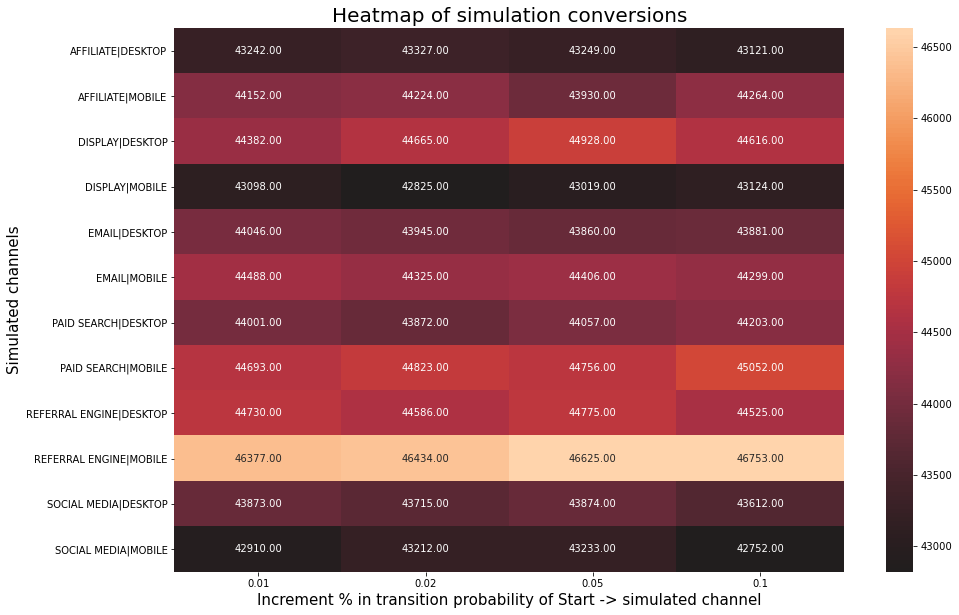

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

res = res.astype(float)
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(res, annot = True, robust = True, fmt = ".2f", center = converted)

plt.title('Heatmap of simulation conversions', fontsize = 20) # title with fontsize 20
plt.xlabel('Increment % in transition probability of Start -> simulated channel', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Simulated channels', fontsize = 15) # y-axis label with fontsize 15

plt.show()